In [1]:
from re import S
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Loading

In [2]:
# Load the MNIST Dataset
def load_mnist_data(n_train, n_test):
    mnist_dataset = keras.datasets.mnist
    (train_images, train_labels), (
        test_images,
        test_labels,
    ) = mnist_dataset.load_data()

    # Reduce dataset size
    train_images = train_images[:n_train]
    train_labels = train_labels[:n_train]
    test_images = test_images[:n_test]
    test_labels = test_labels[:n_test]

    # Normalize pixel values within 0 and 1
    train_images = train_images / 255
    test_images = test_images / 255

    # Add extra dimension for convolution channels
    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
    return train_images, train_labels, test_images, test_labels


## Quantum Circuit

In [3]:
# Create a quantum circuit
@qml.qnode(qml.device("default.qubit", wires=4))
def circuit(phi, rand_params):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

## Parameter initialization

In [4]:
n_epochs = 100  # Number of optimization epochs
n_layers = 25  # Number of random layers
n_train = 500  # Size of the train dataset
n_test = 100  # Size of the test dataset

In [5]:
np.random.seed(123)  # Seed for NumPy random number generator
tf.random.set_seed(123)  # Seed for TensorFlow random number generator

In [6]:
rand_params = np.random.uniform(
    high=2 * np.pi, size=(n_layers, 4)
) 

## Quanvolution Process

In [7]:
# Quanvolution scheme
def quanv(image, rand_params):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0],
                ],
                rand_params,
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Models

In [8]:
def QuantumModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential(
        [keras.layers.Conv2D(50, (5,5), activation="relu", input_shape=(14,14,4)), keras.layers.MaxPooling2D(pool_size=(2,2), padding="same"), keras.layers.Conv2D(64, (5,5), activation="relu"), keras.layers.MaxPooling2D(pool_size=(2,2), padding="same"), keras.layers.Flatten(), keras.layers.Dense(1024, activation="relu"), keras.layers.Dropout(.4), keras.layers.Dense(10, activation="softmax")])
    

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [9]:
def ClassicalModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained.""" 
    model = keras.models.Sequential(
        [keras.layers.Conv2D(50, (5,5), activation="relu", input_shape=(28,28,1)), keras.layers.MaxPooling2D(pool_size=(2,2), padding="same"), keras.layers.Conv2D(64, (5,5), activation="relu"), keras.layers.MaxPooling2D(pool_size=(2,2), padding="same"), keras.layers.Flatten(), keras.layers.Dense(1024, activation="relu"), keras.layers.Dropout(.4), keras.layers.Dense(10, activation="softmax")])
    model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
    return model

## Dataset loading

In [10]:
train_images, train_labels, test_images, test_labels = load_mnist_data(
    n_train, n_test
)


## Evaluation

In [11]:
PREPROCESS = False

In [12]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img, rand_params))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img, rand_params))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save("q_train_images.npy", q_train_images)
    np.save("q_test_images.npy", q_test_images)
else:
    q_train_images = np.load("q_train_images.npy")
    q_test_images = np.load("q_test_images.npy")

In [13]:
q_model = QuantumModel()
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

2021-12-10 12:13:09.396988: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-10 12:13:09.398340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-12-10 12:13:09.631702: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-10 12:13:09.634512: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-10 12:13:09.802025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
125/125 - 1s - loss: 1.9614 - accuracy: 0.3120 - val_loss: 1.0973 - val_accuracy: 0.7000


2021-12-10 12:13:10.805868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
125/125 - 1s - loss: 0.8238 - accuracy: 0.7200 - val_loss: 0.8456 - val_accuracy: 0.7100
Epoch 3/100
125/125 - 1s - loss: 0.4398 - accuracy: 0.8760 - val_loss: 0.5791 - val_accuracy: 0.8100
Epoch 4/100
125/125 - 1s - loss: 0.2501 - accuracy: 0.9300 - val_loss: 0.4370 - val_accuracy: 0.8500
Epoch 5/100
125/125 - 1s - loss: 0.1500 - accuracy: 0.9580 - val_loss: 0.2874 - val_accuracy: 0.9100
Epoch 6/100
125/125 - 1s - loss: 0.0745 - accuracy: 0.9760 - val_loss: 0.2622 - val_accuracy: 0.8900
Epoch 7/100
125/125 - 1s - loss: 0.0332 - accuracy: 0.9940 - val_loss: 0.2572 - val_accuracy: 0.9000
Epoch 8/100
125/125 - 1s - loss: 0.0225 - accuracy: 0.9980 - val_loss: 0.3624 - val_accuracy: 0.8700
Epoch 9/100
125/125 - 1s - loss: 0.0194 - accuracy: 0.9960 - val_loss: 0.2875 - val_accuracy: 0.9100
Epoch 10/100
125/125 - 1s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.3726 - val_accuracy: 0.8700
Epoch 11/100
125/125 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.2495 - val_accur

In [16]:
c_model = ClassicalModel()
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/100


2021-12-10 12:16:42.454793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


125/125 - 1s - loss: 1.1634 - accuracy: 0.6440 - val_loss: 0.5497 - val_accuracy: 0.8000


2021-12-10 12:16:43.350587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
125/125 - 1s - loss: 0.3267 - accuracy: 0.9040 - val_loss: 0.3794 - val_accuracy: 0.8300
Epoch 3/100
125/125 - 1s - loss: 0.2074 - accuracy: 0.9420 - val_loss: 0.1917 - val_accuracy: 0.9500
Epoch 4/100
125/125 - 1s - loss: 0.0798 - accuracy: 0.9740 - val_loss: 0.4747 - val_accuracy: 0.8800
Epoch 5/100
125/125 - 1s - loss: 0.0900 - accuracy: 0.9780 - val_loss: 0.1109 - val_accuracy: 0.9900
Epoch 6/100
125/125 - 1s - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.1678 - val_accuracy: 0.9400
Epoch 7/100
125/125 - 1s - loss: 0.0184 - accuracy: 0.9960 - val_loss: 0.0867 - val_accuracy: 0.9700
Epoch 8/100
125/125 - 1s - loss: 0.0155 - accuracy: 0.9980 - val_loss: 0.1486 - val_accuracy: 0.9500
Epoch 9/100
125/125 - 1s - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.2385 - val_accuracy: 0.9100
Epoch 10/100
125/125 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9700
Epoch 11/100
125/125 - 1s - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.1820 - val_accur

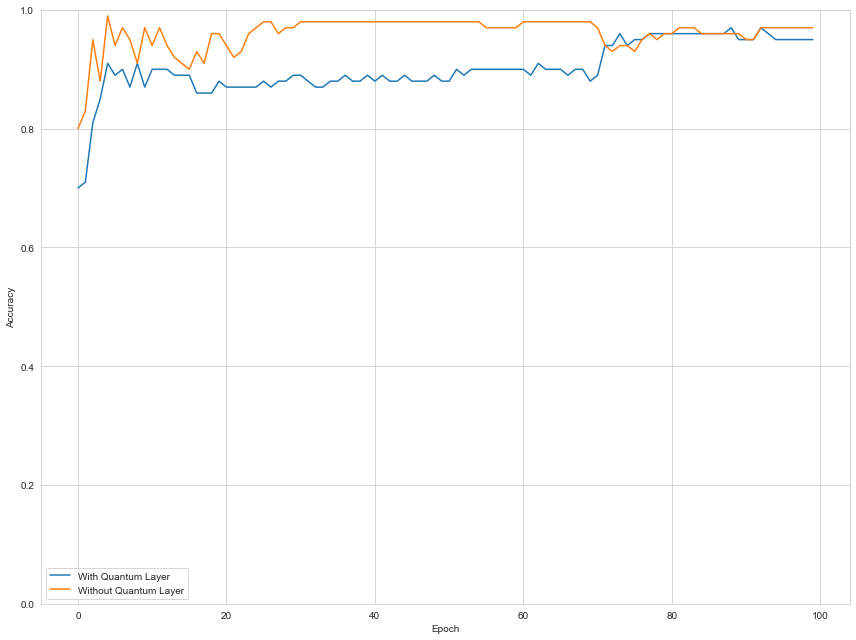

In [17]:
sns.set_style("whitegrid")
sns.color_palette("bright")
fig, ax1 = plt.subplots(1, 1, figsize=(12, 9))
sns.lineplot(
    data=q_history.history["val_accuracy"],
    ax=ax1,
    label="With Quantum Layer",
)
sns.lineplot(
    data=c_history.history["val_accuracy"],
    ax=ax1,
    label="Without Quantum Layer",
)
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
plt.savefig("accuracy.png")
plt.tight_layout()
plt.show()

## Model illustration

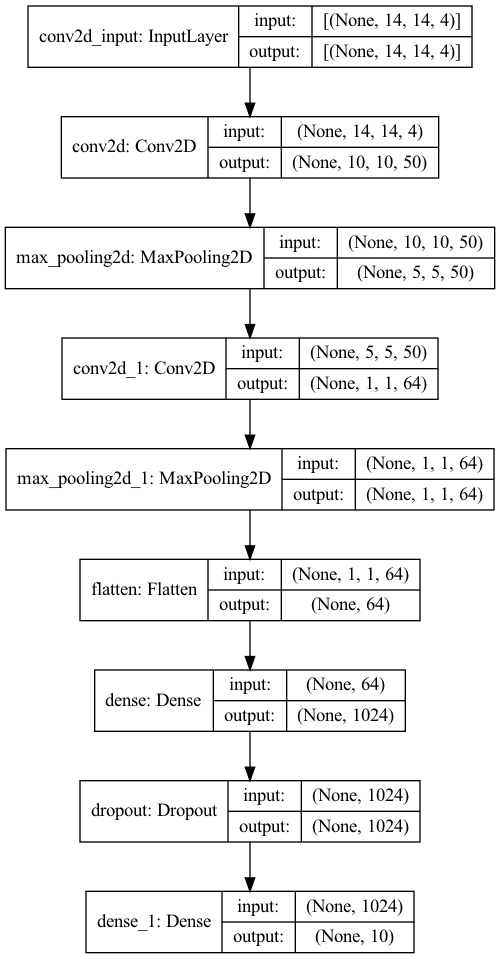

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(q_model, to_file="quantum_model.png", show_shapes=True)

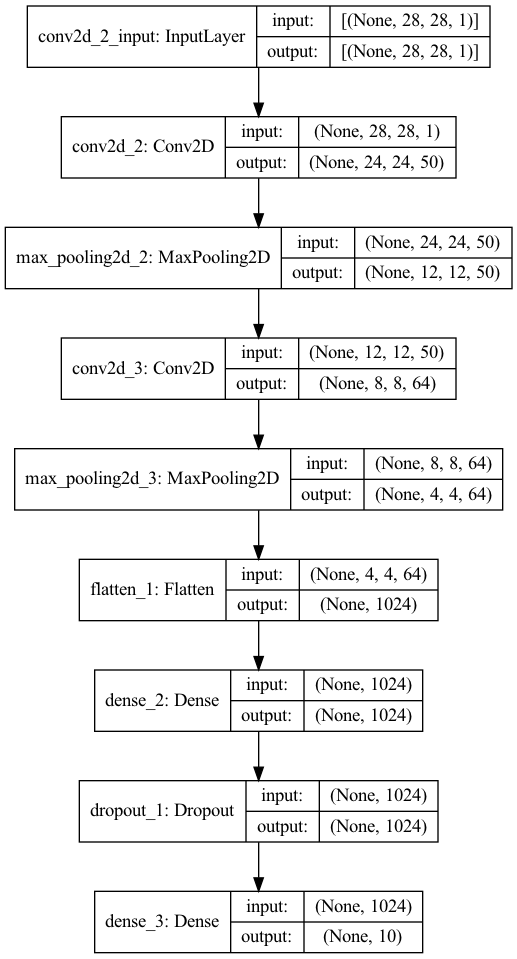

In [18]:
plot_model(c_model, to_file="classical_model.png", show_shapes=True)